In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["QISKIT_IN_PARALLEL"] = 'TRUE'

In [3]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target

from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_manila")

In [74]:
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend, ParallelTransmonTestBackend
pulse_backend = ParallelTransmonTestBackend(noise=False, seed=0) 
pulse_backend1 = SingleTransmonTestBackend(noise=True,gamma_1=10000.0)

### Works both with IQ+Discriminator [or] with Statevector.sample_counts() with collapse |2> into |1>

In [75]:
# from qiskit_experiments.data_processing.discriminator import BaseDiscriminator

# class FakeDiscriminator(BaseDiscriminator):
#     """A fake discriminator class for testing."""

#     def predict(self, data):
#         """Discriminate the data"""
#         return ["0" if iq[0] > iq[1] else "1" for iq in data]

#     def config(self):
#         """Config method."""
#         return {}

#     def is_trained(self):
#         """This test discriminator is always trained."""
#         return True

# pulse_backend.discriminator = FakeDiscriminator()

In [76]:
import numpy as np

from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)
# from qiskit_experiments.test.pulse_backend import ParallelTransmonTestBackend, SingleTransmonTestBackend
# pulse_backend = ParallelTransmonTestBackend(noise=False)
# pulse_backend1 = SingleTransmonTestBackend(noise=False)
# qubit = 0
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(pulse_backend, libraries=[library])

In [77]:
from qiskit import transpile

In [78]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal


rabi0 = RoughXSXAmplitudeCal(
    0, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 55)
)

rabi1 = RoughXSXAmplitudeCal(
    1, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 55)
)

freq01_estimate = pulse_backend.defaults().qubit_freq_est[0]
frequencies = np.linspace(freq01_estimate - 15e6, freq01_estimate + 15e6, 51)

spec1 = RoughFrequencyCal(
    1, cals, backend=pulse_backend,frequencies=frequencies)
spec1.set_experiment_options(amp=0.005)

In [79]:
d=spec1.run().block_for_results()

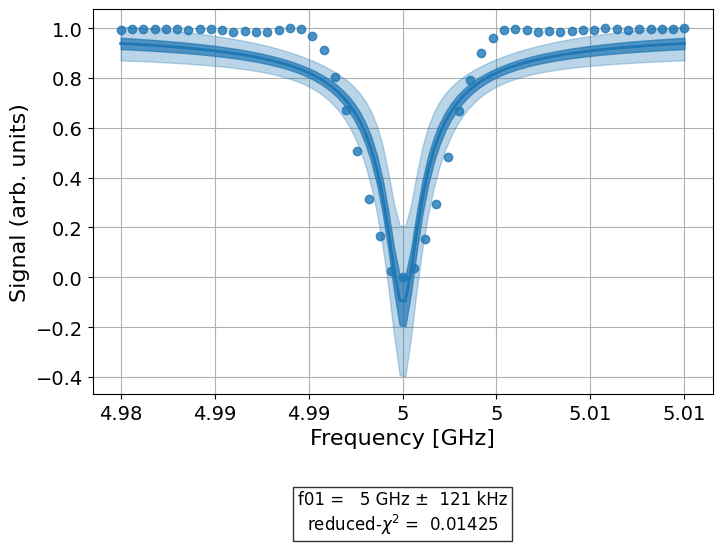

In [80]:
# print(d.analysis_results()[0])
d.figure(0)

In [81]:
print(d.analysis_results()[0])

AnalysisResult
- name: @Parameters_ResonanceAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_lorentzian(x) = a * abs(kappa) / sqrt(kappa**2 + 4 * (x - freq)**2) + b
 - success: True
 - number of function evals: 4
 - degree of freedom: 47
 - chi-square: 0.6695644811880084
 - reduced chi-square: 0.014246052791234221
 - Akaike info crit.: -212.98062537670387
 - Bayesian info crit.: -205.25332284580657
 - init params:
  * a = -0.9928700118315696
  * kappa = 5400000.0
  * freq = 5000000000.0
  * b = 0.9928700118315696
 - fit params:
  * a = -1.1114582425068857 ± 0.0999169453007809
  * kappa = 1619609.0575400451 ± 317854.60323595523
  * freq = 5000006982.89994 ± 121042.47231053183
  * b = 0.9983653311621676 ± 0.029599163719521825
 - correlations:
  * (a, b) = -0.036947891688397405
  * (kappa, freq) = -0.0024102753689239365
  * (a, freq) = -0.0018170029259357424
  * (freq, b) = -0.0013355038321768364
  * (a, kappa) = 0.5961057033044652
  * (k

In [110]:
spec1.run_options

Options(meas_level=<MeasLevel.KERNELED: 1>, meas_return='avg')

In [111]:
rabi1.run_options

Options(meas_level=<MeasLevel.KERNELED: 1>, meas_return='single')

In [82]:
from qiskit_experiments.framework.composite import ParallelExperiment

In [85]:
rabi_parallel = ParallelExperiment([rabi0, spec1],backend=pulse_backend)

In [86]:
rabi_parallel.circuits()[0].draw()

┌────────────┐    ░ ┌─┐   
  q_0: ────┤ Rabi(-0.1) ├────░─┤M├───
       ┌───┴────────────┴──┐ ░ └╥┘┌─┐
  q_1: ┤ Spec(-15000000.0) ├─░──╫─┤M├
       └───────────────────┘ ░  ║ └╥┘
c1186: ═════════════════════════╩══╬═
                                   ║ 
c1241: ════════════════════════════╩═

In [87]:
from qiskit.qobj.utils import MeasLevel

In [106]:
rabi_parallel.set_run_options(meas_level=MeasLevel.KERNELED, meas_return="avg")

In [107]:
rabi_data = rabi_parallel.run(shots=4000).block_for_results()

/home/rupeshknn/mambaforge/envs/exp/lib/python3.8/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Component experiment 0


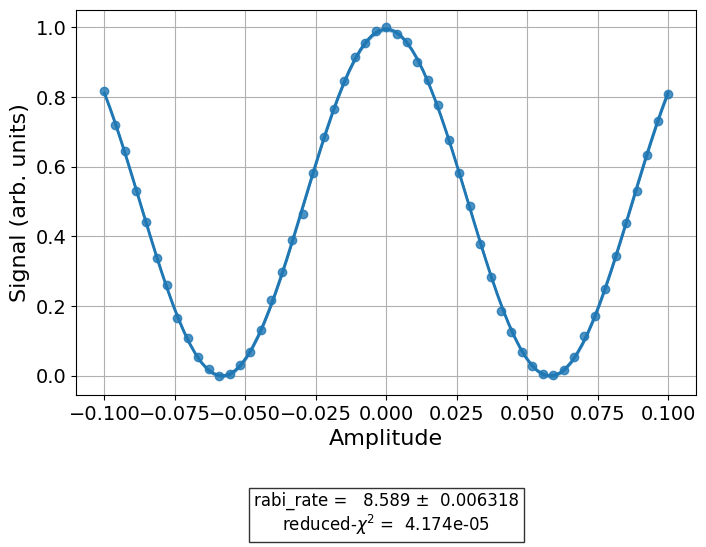

AnalysisResult
- name: @Parameters_OscillationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_cos(x) = amp * cos(2 * pi * freq * x + phase) + base
 - success: True
 - number of function evals: 10
 - degree of freedom: 51
 - chi-square: 0.002128516654826117
 - reduced chi-square: 4.1735620682865035e-05
 - Akaike info crit.: -550.7814723304894
 - Bayesian info crit.: -542.7521395895594
 - init params:
  * amp = 0.5147015683531012
  * freq = 9.820047627230998
  * phase = 1.5707963267948966
  * base = 0.4852984316468988
 - fit params:
  * amp = 0.497830469986697 ± 0.0013213753989328196
  * freq = 8.58866238432787 ± 0.006318426029291369
  * phase = 0.0015596326176176322 ± 0.002368526868120584
  * base = 0.4971039444037439 ± 0.0009435070420826933
 - correlations:
  * (freq, base) = -0.33931542990327535
  * (amp, freq) = -0.08217806505164223
  * (phase, base) = -0.00036907464361151933
  * (amp, phase) = -0.0003576450442328709
  * (freq, phas

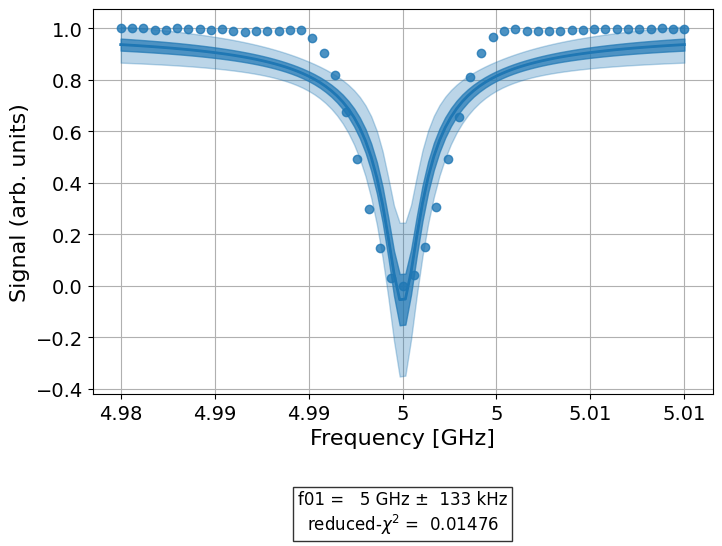

AnalysisResult
- name: @Parameters_ResonanceAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_lorentzian(x) = a * abs(kappa) / sqrt(kappa**2 + 4 * (x - freq)**2) + b
 - success: True
 - number of function evals: 4
 - degree of freedom: 47
 - chi-square: 0.6935865725526977
 - reduced chi-square: 0.014757161118142506
 - Akaike info crit.: -211.18294712010515
 - Bayesian info crit.: -203.45564458920785
 - init params:
  * a = -0.9935046093666935
  * kappa = 6000000.0
  * freq = 5000000000.0
  * b = 0.9935046093666935
 - fit params:
  * a = -1.0668941407364803 ± 0.09815487192302706
  * kappa = 1759205.785662797 ± 360283.5640669892
  * freq = 4999994370.200863 ± 133014.43154873527
  * b = 0.998318295300225 ± 0.031164697607954105
 - correlations:
  * (a, b) = -0.04508152828864461
  * (freq, b) = 0.0006344892457617994
  * (a, freq) = 0.0007571663813288531
  * (kappa, freq) = 0.0010716251274484698
  * (a, kappa) = 0.581320056291285
  * (kappa, 

In [108]:
for i, sub_data in enumerate(rabi_data.child_data()):
    print("Component experiment",i)
    display(sub_data.figure(0))
    for result in sub_data.analysis_results():
        print(result)